## Setup

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from codebase.models.model2 import model2
from codebase.train import train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")
torch.cuda.set_per_process_memory_fraction(0.8)

Usando dispositivo: cuda


In [2]:
# cargamos los datos small
data = pd.read_csv('data/es_MX-es_LF_small.txt', sep='\t', header=None)
data.columns = ['spanish', 'lunfardo']
data.head()

,spanish,lunfardo
0,representaciones de la tierra y el agua de sis...,¡las labras de la tierra y el agua mierda son ...
1,gente nadando en la alberca 2022 es una de las...,gente chapoteando en la pileta 2022 es uno de ...
2,tierra del sol se complace en presentar vicent...,tierra del sol se pone el moño pa' presentarte...
3,"trabajando con maestría diversas temáticas, si...","con un chamuyo bárbaro, el siso se mandó una b..."
4,la galería tierra del sol se encuentra en el 7...,la canchita tierra del sol la garrás en el 741...


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data['spanish'], data['lunfardo'],
                                                  test_size=0.1, random_state=28)

model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

class dataset_token(Dataset):
    def __init__(self, x, y):
        self.pairs = list(zip(x, y))

    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        xs, ys = self.pairs[idx]
        tokenized_xs = torch.tensor(tokenizer.encode(xs)).to(device)
        tokenized_ys = torch.tensor(tokenizer.encode(ys)).to(device)

        return {
            'input': tokenized_xs,
            'target': tokenized_ys,
            'input_length': torch.tensor(tokenized_xs.shape[0]).to(device),
            'target_length': torch.tensor(tokenized_ys.shape[0]).to(device)
    }

train_dataset = dataset_token(X_train, y_train)
val_dataset = dataset_token(X_val, y_val)

print('Primer elemento del dataset de entrenamiento:', train_dataset[1])

Primer elemento del dataset de entrenamiento: {'input': tensor([  101, 10173, 10192, 17009, 23877, 94239, 13686, 12692, 11048, 60078,
          117, 10161, 75227, 33891, 16803, 10329, 10181, 10130, 50373, 10112,
        10542, 21963,   119, 10117, 75227, 51115, 31982, 10134, 37149, 10181,
        10128, 26556, 10106, 57040, 35393, 10102, 23145, 28695, 15993, 10352,
          119, 50981, 10128, 28157, 24760, 10239, 65714, 74698, 10109, 10106,
        15489,   119, 15195, 13139, 14478, 11801, 10131,   143, 10877, 29298,
        10107,   167, 10102, 31546, 59002, 11280,   119, 10791, 10181, 14478,
        11801, 10281,   143, 10106, 47727, 10992, 10102, 36271, 33891,   119,
          102], device='cuda:0'), 'target': tensor([  101, 10173, 10192, 80158, 10378, 10102, 14727, 12519, 11449, 10743,
        14258, 10132,   117, 10161, 75227, 33891, 10102, 16803, 10130, 12895,
        11596, 10119, 41260, 11259, 10126, 10387, 10312, 10208,   119, 10117,
        75227, 51115, 31982, 10134, 37149,

In [4]:
def custom_collate(batch):
    inputs = [item['input'] for item in batch]
    targets = [item['target'] for item in batch]
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=tokenizer.pad_token_id)  # (batch, max_len, 768)
    padded_targets = pad_sequence(targets, batch_first=True, padding_value=tokenizer.pad_token_id)
    return {'input': padded_inputs,
            'target': padded_targets,
            'input_length': torch.tensor([item['input_length'] for item in batch]),
            'target_length': torch.tensor([item['target_length'] for item in batch])}

## Intento 1
Experimento con distintos hiperparametros 

In [5]:
# Inicializa el modelo 
model = model2(name='BERT + Transformers').to(device)

print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo creado con 161775255 parámetros


In [ ]:
BATCH_SIZE = 1

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)

NUM_EPOCHS = 5
LR = 1e-3
train(model, train_dataloader, val_dataloader, epoch_max=NUM_EPOCHS, lr=LR)

Iniciando entrenamiento...
--------------------------------------------------


c:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
c:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Época 5/5:
  Pérdida Entrenamiento: 6.1180
  Pérdida Testeo: 6.8428
  Empeorando
Entrenamiento completado! Tiempo total: 433.38 segundos


([6.953444611294106,
  6.235646995442767,
  6.171508249788959,
  6.144947244836447,
  6.11800951255984],
 [6.627228915691376,
  6.678502236803372,
  6.780250042676926,
  6.809046372771263,
  6.8428047349055605])

## Intento 2

In [5]:
# Inicializa el modelo 
model = model2(name='BERT + Transformers',
               d_model=256,
               nhead=2,
               num_encoder_layers=6,
               num_decoder_layers=6,
               dim_feedforward=1024
               ).to(device)

print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo creado con 38467991 parámetros


In [6]:
BATCH_SIZE = 1

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate)

NUM_EPOCHS = 5
LR = 1e-3
train_loss, val_loss = train(model, train_dataloader, val_dataloader, epoch_max=NUM_EPOCHS, lr=LR)

Iniciando entrenamiento...
--------------------------------------------------


c:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
c:\Users\aaron\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


Época 5/5:
  Pérdida Entrenamiento: 6.0398
  Pérdida Testeo: 6.8456
  Empeorando
Entrenamiento completado! Tiempo total: 243.56 segundos


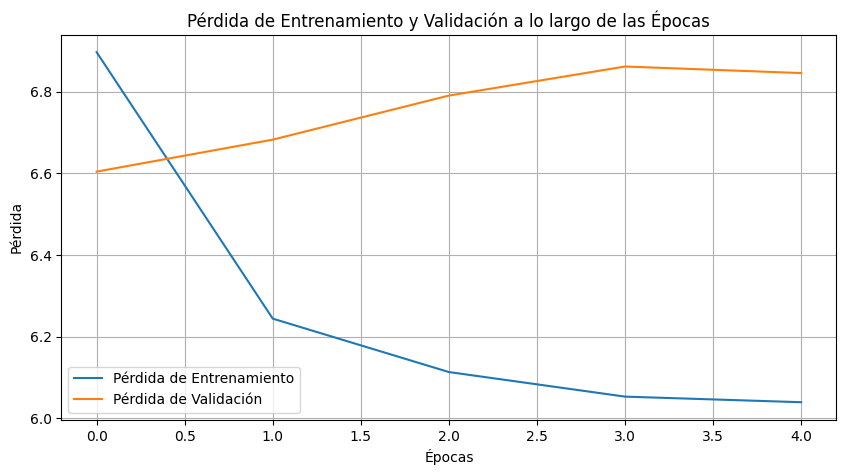

In [7]:
def plot_losses(train_loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Pérdida de Entrenamiento')
    plt.plot(val_loss, label='Pérdida de Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Pérdida de Entrenamiento y Validación a lo largo de las Épocas')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_loss, val_loss)